<a href="https://colab.research.google.com/github/sayo-134/qiskit_programming/blob/main/custom_backendv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create a custom BackendV2

In [1]:
!pip install graphviz

In [2]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 10.2 MB/s eta 0:00:00


In [3]:
!pip install qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 69.7 MB/s eta 0:00:00


In [4]:
!pip install rustworkx

In [5]:
!pip install numpy
!pip install matplotlib

In [7]:
import qiskit
print(qiskit.__version__)

2.0.2


In [8]:
import numpy as np
import rustworkx as rx

from qiskit.providers import BackendV2, Options
from qiskit.transpiler import Target, InstructionProperties
from qiskit.circuit.library import XGate, SXGate, RZGate, CZGate, ECRGate
from qiskit.circuit import Measure, Delay, Parameter, Reset
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_gate_map


class FakeLOCCBackend(BackendV2):
    """Fake multi chip backend."""

    def __init__(self, distance=3, number_of_chips=3):
        """Instantiate a new fake multi chip backend.

        Args:
            distance (int): The heavy hex code distance to use for each chips'
                coupling map. This number **must** be odd. The distance relates
                to the number of qubits by:
                :math:`n = \\frac{5d^2 - 2d - 1}{2}` where :math:`n` is the
                number of qubits and :math:`d` is the ``distance``
            number_of_chips (int): The number of chips to have in the multichip backend
                each chip will be a heavy hex graph of ``distance`` code distance.
        """
        super().__init__(name="Fake LOCC backend")
        # Create a heavy-hex graph using the rustworkx library, then instantiate a new target
        self._graph = rx.generators.directed_heavy_hex_graph(
            distance, bidirectional=False
        )
        num_qubits = len(self._graph) * number_of_chips
        self._target = Target(
            "Fake multi-chip backend", num_qubits=num_qubits
        )

        # Generate instruction properties for single qubit gates and a measurement, delay,
        #  and reset operation to every qubit in the backend.
        rng = np.random.default_rng(seed=12345678942)
        rz_props = {}
        x_props = {}
        sx_props = {}
        measure_props = {}
        delay_props = {}

        # Add 1q gates. Globally use virtual rz, x, sx, and measure
        for i in range(num_qubits):
            qarg = (i,)
            rz_props[qarg] = InstructionProperties(error=0.0, duration=0.0)
            x_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4),
                duration=rng.uniform(1e-8, 9e-7),
            )
            sx_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4),
                duration=rng.uniform(1e-8, 9e-7),
            )
            measure_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-3, 1e-1),
                duration=rng.uniform(1e-8, 9e-7),
            )
            delay_props[qarg] = None
        self._target.add_instruction(XGate(), x_props)
        self._target.add_instruction(SXGate(), sx_props)
        self._target.add_instruction(RZGate(Parameter("theta")), rz_props)
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(Reset(), measure_props)

        self._target.add_instruction(Delay(Parameter("t")), delay_props)
        # Add chip local 2q gate which is CZ
        cz_props = {}
        for i in range(number_of_chips):
            for root_edge in self._graph.edge_list():
                offset = i * len(self._graph)
                edge = (root_edge[0] + offset, root_edge[1] + offset)
                cz_props[edge] = InstructionProperties(
                    error=rng.uniform(7e-4, 5e-3),
                    duration=rng.uniform(1e-8, 9e-7),
                )
        self._target.add_instruction(CZGate(), cz_props)

        cx_props = {}
        # Add interchip 2q gates which are ecr (effectively CX)
        # First determine which nodes to connect
        node_indices = self._graph.node_indices()
        edge_list = self._graph.edge_list()
        inter_chip_nodes = {}
        for node in node_indices:
            count = 0
            for edge in edge_list:
                if node == edge[0]:
                    count += 1
            if count == 1:
                inter_chip_nodes[node] = count
        # Create inter-chip ecr props
        cx_props = {}
        inter_chip_edges = list(inter_chip_nodes.keys())
        for i in range(1, number_of_chips):
            offset = i * len(self._graph)
            edge = (
                inter_chip_edges[1] + (len(self._graph) * (i - 1)),
                inter_chip_edges[0] + offset,
            )
            cx_props[edge] = InstructionProperties(
                error=rng.uniform(7e-4, 5e-3),
                duration=rng.uniform(1e-8, 9e-7),
            )

        self._target.add_instruction(ECRGate(), cx_props)

    @property
    def target(self):
        return self._target

    @property
    def max_circuits(self):
        return None

    @property
    def graph(self):
        return self._graph

    @classmethod
    def _default_options(cls):
        return Options(shots=1024)

    def run(self, circuit, **kwargs):
        raise NotImplementedError(
            "This backend does not contain a run method"
        )

## Visualize Backends

In [9]:
backend = FakeLOCCBackend(3, 3)


target = backend.target
coupling_map_backend = target.build_coupling_map()


coordinates = [
    (3, 1),
    (3, -1),
    (2, -2),
    (1, 1),
    (0, 0),
    (-1, -1),
    (-2, 2),
    (-3, 1),
    (-3, -1),
    (2, 1),
    (1, -1),
    (-1, 1),
    (-2, -1),
    (3, 0),
    (2, -1),
    (0, 1),
    (0, -1),
    (-2, 1),
    (-3, 0),
]

single_qubit_coordinates = []
total_qubit_coordinates = []


for coordinate in coordinates:
    total_qubit_coordinates.append(coordinate)

for coordinate in coordinates:
    total_qubit_coordinates.append(
        (-1 * coordinate[0] + 1, coordinate[1] + 4)
    )

for coordinate in coordinates:
    total_qubit_coordinates.append((coordinate[0], coordinate[1] + 8))


line_colors = ["#adaaab" for edge in coupling_map_backend.get_edges()]
ecr_edges = []

# Get tuples for the edges which have an ecr instruction attached
for instruction in target.instructions:
    if instruction[0].name == "ecr":
        ecr_edges.append(instruction[1])

for i, edge in enumerate(coupling_map_backend.get_edges()):
    if edge in ecr_edges:
        line_colors[i] = "#000000"

Fake LOCC backend


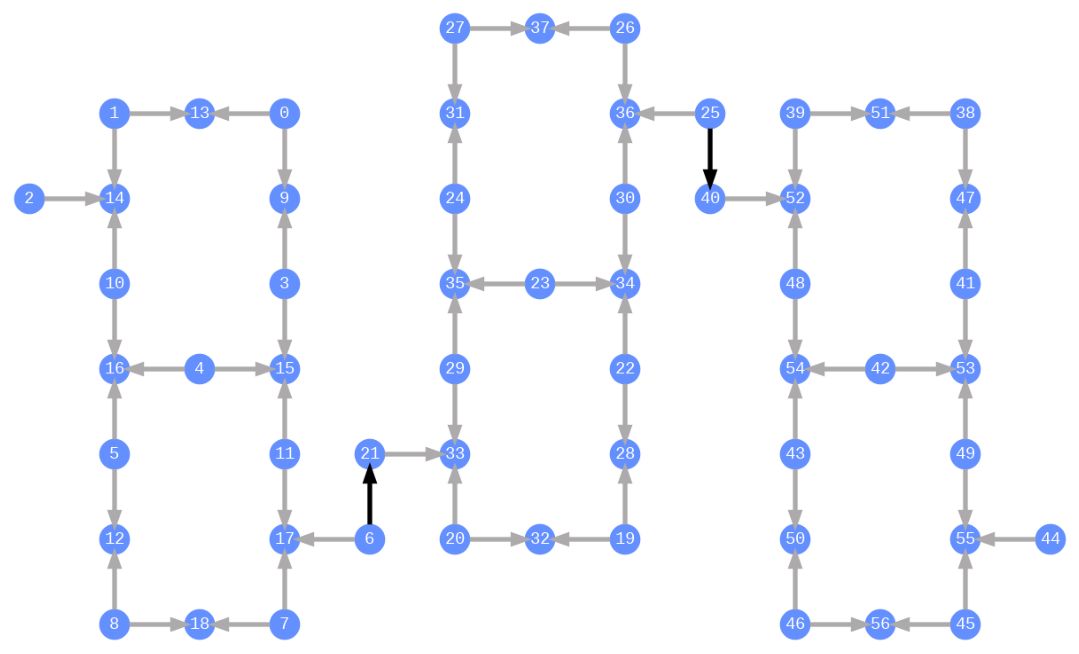

In [10]:
print(backend.name)
plot_gate_map(
    backend,
    plot_directed=True,
    qubit_coordinates=total_qubit_coordinates,
    line_color=line_colors,
)

# Transpile against custom backends

In [14]:
from qiskit.transpiler import generate_preset_pass_manager

num_qubits = 50
ghz = QuantumCircuit(num_qubits)
ghz.h(range(num_qubits))
ghz.cx(0, range(1, num_qubits))
op_counts = ghz.count_ops()

print("Pre-Transpilation: ")
print(f"CX gates: {op_counts['cx']}")
print(f"H gates: {op_counts['h']}")
print("\n", 30 * "#", "\n")

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
transpiled_ghz = pm.run(ghz)
op_counts = transpiled_ghz.count_ops()

print("Post-Transpilation: ")
print(f"CZ gates: {op_counts['cz']}")
print(f"ECR gates: {op_counts['ecr']}")
print(f"SX gates: {op_counts['sx']}")
print(f"RZ gates: {op_counts['rz']}")

Pre-Transpilation: 
CX gates: 49
H gates: 50

 ############################## 

Post-Transpilation: 
CZ gates: 171
ECR gates: 6
SX gates: 352
RZ gates: 228


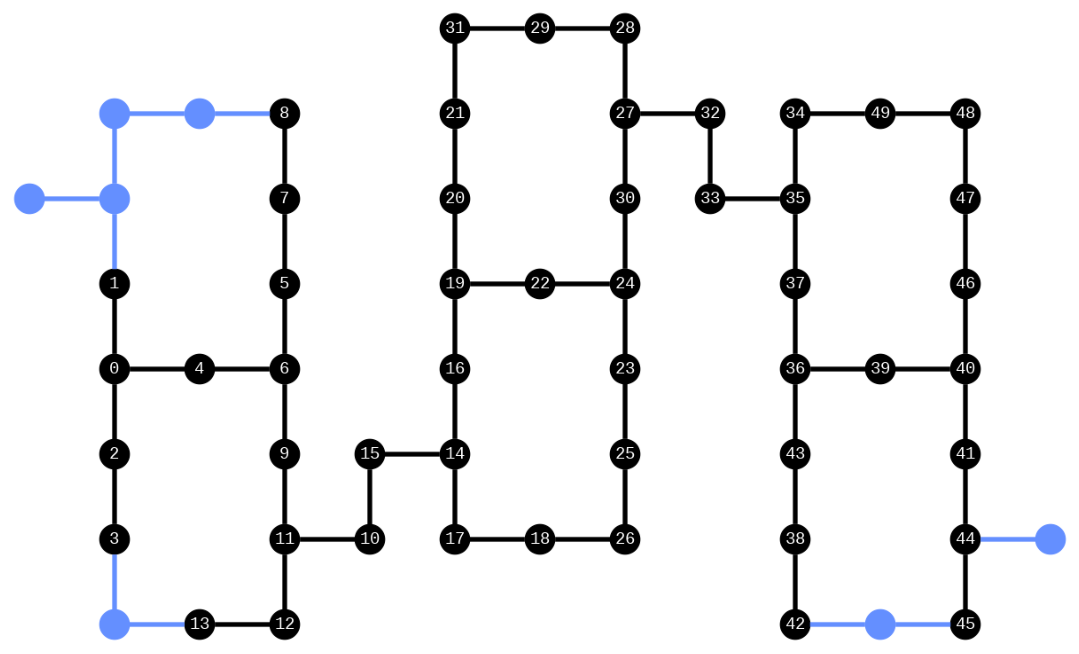

In [15]:
from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(
    transpiled_ghz, backend, qubit_coordinates=total_qubit_coordinates
)

# Create unique backends

In [16]:
class FakeTorusBackend(BackendV2):
    """Fake multi chip backend."""

    def __init__(self):
        """Instantiate a new backend that is inspired by a toric code"""
        super().__init__(name="Fake LOCC backend")
        graph = rx.generators.directed_grid_graph(20, 20)
        for column in range(20):
            graph.add_edge(column, 19 * 20 + column, None)
        for row in range(20):
            graph.add_edge(row * 20, row * 20 + 19, None)
        num_qubits = len(graph)
        rng = np.random.default_rng(seed=12345678942)
        rz_props = {}
        x_props = {}
        sx_props = {}
        measure_props = {}
        delay_props = {}
        self._target = Target("Fake Kookaburra", num_qubits=num_qubits)
        # Add 1q gates. Globally use virtual rz, x, sx, and measure
        for i in range(num_qubits):
            qarg = (i,)
            rz_props[qarg] = InstructionProperties(error=0.0, duration=0.0)
            x_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4),
                duration=rng.uniform(1e-8, 9e-7),
            )
            sx_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4),
                duration=rng.uniform(1e-8, 9e-7),
            )
            measure_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-3, 1e-1),
                duration=rng.uniform(1e-8, 9e-7),
            )
            delay_props[qarg] = None
        self._target.add_instruction(XGate(), x_props)
        self._target.add_instruction(SXGate(), sx_props)
        self._target.add_instruction(RZGate(Parameter("theta")), rz_props)
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(Reset(), measure_props)
        self._target.add_instruction(Delay(Parameter("t")), delay_props)
        cz_props = {}
        for edge in graph.edge_list():
            cz_props[edge] = InstructionProperties(
                error=rng.uniform(7e-4, 5e-3),
                duration=rng.uniform(1e-8, 9e-7),
            )
        self._target.add_instruction(CZGate(), cz_props)

    @property
    def target(self):
        return self._target

    @property
    def max_circuits(self):
        return None

    @classmethod
    def _default_options(cls):
        return Options(shots=1024)

    def run(self, circuit, **kwargs):
        raise NotImplementedError("Lasciate ogne speranza, voi ch'intrate")

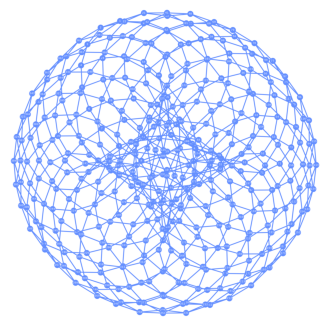

In [17]:
backend = FakeTorusBackend()
# We set `figsize` to a smaller size to make the documentation website faster
# to load. Normally, you do not need to set the argument.
plot_gate_map(backend, figsize=(4, 4))

In [18]:
num_qubits = int(backend.num_qubits / 2)
full_device_bv = QuantumCircuit(num_qubits, num_qubits - 1)
full_device_bv.x(num_qubits - 1)
full_device_bv.h(range(num_qubits))
full_device_bv.cx(range(num_qubits - 1), num_qubits - 1)
full_device_bv.h(range(num_qubits))
full_device_bv.measure(range(num_qubits - 1), range(num_qubits - 1))
tqc = transpile(full_device_bv, backend, optimization_level=3)
op_counts = tqc.count_ops()
print(f"CZ gates: {op_counts['cz']}")
print(f"X gates: {op_counts['x']}")
print(f"SX gates: {op_counts['sx']}")
print(f"RZ gates: {op_counts['rz']}")

CZ gates: 763
X gates: 13
SX gates: 1442
RZ gates: 903
